# Music Culture and Psychological States
## Replicating and Expanding DeWall et al. 2011 "Tuning in to Psychological Change"<sup>1</sup>

DeWall et al. 2011 tested three music lyric legisign relationships for evidence that replication of self-focus and antisocial legisigns has increased over time in song lyrics from the Billboard Hot 100 and that the replication of other-focus, social interactions, and positive emotion legisigns has decreased. Confirming their expectations, they argue that this pattern in musical legisign replication can be generalized to say that U.S. culture has become more self-focused and antisocial. If we accept Frith's assertion that songs "provide people with the means to articulate [...] feelings" (1996: 164)<sup>2</sup>, then this finding of increasingly antisocial and self-focused language within the most popular U.S. songs should be suggestive of a more general cultural psychological state. In Peircean terms, this means that, on one level, each word in the lyrics would be a replica of a dicent indexical legisign. For instance, replications of "self-focus" I/me/my/mine words stand for singer singing the word (and for listener who uses the word to articulate their own feelings), indexing their internal psychological state, and producing a dicent interpretant associating that psychological state with themselves. Today, we're going to attempt to replicate and expand DeWall et al.'s study (using Billboard Hot 100 song lyrics from 1950-2015) by answering the following questions:

1. Can we identify increasing self-focus (first person singular pronouns) and decreasing other-focus ("communion," first person plural pronouns)?
2. Can we identify decreasing "social connection" legisign replication?
3. Is there an increase in antisocial legisign replication and a decrease in pro-social legisign replication?
4. Extending DeWall et al.'s study, are the topics and themes in songs changing as well? Do topics of music also reflect this anti-social, self-focus interpretation?

Our data comes from a couple (see [here](https://github.com/kevinschaich/billboard) and [here](https://towardsdatascience.com/billboard-hot-100-analytics-using-data-to-understand-the-shift-in-popular-music-in-the-last-60-ac3919d39b49)) of public Github repositories that compiled extensive historical data about the Billboard Hot 100 from 1950-2015, along with data about the music itself from Spotify.
    
Note: The authors of the study tested individual words, but do not provide all of the words they used for Social Connection, Angry, Positive Emotion (unless the few words provided in the text on page 3 are the only words they checked). In the original study, DeWall et al. consider music genre as dummy variables in their regression models, as well as changes in ranking formula  to account for digital downloads and streamed media. We will not consider these factors for analysis as genre is a bit tricky to pin down because so many songs cross genre-boundaries, the genres themselves have changed through time, and this information is often not available in early songs from the 50s. We will instead consider the overall effects across genres and ranking formulas.
    
---------------------------------
  
<sup>1</sup>DeWall, C. N., Pond, R. S., Jr., Campbell, W. K., & Twenge, J. M. 2011. "Tuning in to Psychological Change: Linguistic Markers of Psychological Traits and Emotions Over Time in Popular U.S. Song Lyrics." *Psychology of Aesthetics*, Creativity, and the Arts.

<sup>2</sup>Frith, Simon. 1996. “Songs as Texts.” In *Performing Rites: On the Value of Popular Music*. Cambridge,
MA: Harvard University Press, pp. 158-182.


In [64]:
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
from gensim import corpora, models

# Some Functions from Last Time to get us started:
def get_wordnet_pos(word):

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text):

    stop = nltk.corpus.stopwords.words('english') + list(string.punctuation)
    tokens = [i for i in nltk.word_tokenize(text.lower()) if i not in stop]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

def get_tokens(text):
    # drop punctuation, but keep stopwords for initial word counting
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = [i for i in nltk.word_tokenize(text.lower())]
    return tokens

def fill_topic_weights(df_row, bow_corpus):
    # Fill topic weights for topics in songs
    try:
        for i in ldamodel[bow_corpus[df_row.name]]:
            df_row[str(i[0])] = i[1]
    except:
        return df_row
    return df_row

def top_songs_by_topic(ldamodel, corpus, ntop=1):
    topn_songs_by_topic = {}
    for i in range(len(ldamodel.print_topics())):
        # For each topic, collect the most representative song(s) (i.e. highest probability containing words belonging to topic):
        top = sorted(zip(range(len(corpus)), ldamodel[corpus]), reverse=True, key=lambda x: abs(dict(x[1]).get(i, 0.0)))
        topn_songs_by_topic[i] = [j[0] for j in top[:ntop]]
        # Print out the topn songs for each topic and return their indices as a dictionary for further analysis:
        print("Topic " + str(i))
        print(music_df[['title','year','artist']].loc[topn_songs_by_topic[i]])
        print("*******************************")
    return topn_songs_by_topic

In [2]:
music_df = pd.read_csv('music_df.csv')
music_df['year_bin'] = music_df['year_bin'].apply(lambda x: '20'+x if (x == '10s') or (x == '00s') else '19'+x)

In [4]:
print(music_df.columns)
music_df.head()

Index(['lyrics', 'num_syllables', 'pos', 'year', 'fog_index', 'flesch_index',
       'num_words', 'num_lines', 'title', 'f_k_grade', 'artist',
       'difficult_words', 'num_dupes', 'neg', 'neu', 'compound', 'id',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'uri', 'analysis_url',
       'artist_with_features', 'year_bin', 'image', 'cluster', 'Gender'],
      dtype='object')


,lyrics,num_syllables,pos,year,fog_index,flesch_index,num_words,num_lines,title,f_k_grade,...,tempo,duration_ms,time_signature,uri,analysis_url,artist_with_features,year_bin,image,cluster,Gender
0,"Mona Lisa, Mona Lisa, men have named you\nYou'...",189.0,0.199,1950,5.2,88.74,145,17,Mona Lisa,2.9,...,86.198,207573.0,3,spotify:track:3k5ycyXX5qsCjLd7R2vphp,https://api.spotify.com/v1/audio-analysis/3k5y...,NaN,1950s,https://i.scdn.co/image/a4c0918f13b67aa8d9f4ea...,String Lover,male
1,I wanna be Loved\nBy Andrews Sisters\n\nOooo-o...,270.9,0.224,1950,4.4,82.31,189,31,I Wanna Be Loved,3.3,...,170.869,198027.0,5,spotify:track:4UY81WrDU3jTROGaKuz4uZ,https://api.spotify.com/v1/audio-analysis/4UY8...,Gordon Jenkins,1950s,https://i.scdn.co/image/42e4dc3ab9b190056a1ca1...,String Lover,Group
2,I was dancing with my darling to the Tennessee...,174.6,0.351,1950,5.2,88.74,138,16,Tennessee Waltz,2.9,...,86.335,182733.0,3,spotify:track:6DKt9vMnMN0HmlnK3EAHRQ,https://api.spotify.com/v1/audio-analysis/6DKt...,NaN,1950s,https://i.scdn.co/image/353b05113b1a140d64d83d...,String Lover,female
3,Each time I hold someone new\nMy arms grow col...,135.9,0.231,1950,4.4,99.23,117,18,I'll Never Be Free,0.9,...,82.184,158000.0,3,spotify:track:0KnD456yC5JuweN932Ems3,https://api.spotify.com/v1/audio-analysis/0KnD...,Kay Starr,1950s,https://i.scdn.co/image/4bd427bb9181914d0fa448...,String Lover,male
4,"Unfortunately, we are not licensed to display ...",46.8,0.079,1950,6.0,69.79,32,3,All My Love,6.0,...,123.314,190933.0,4,spotify:track:05sXHTLqIpwywbpui1JT4o,https://api.spotify.com/v1/audio-analysis/05sX...,NaN,1950s,https://i.scdn.co/image/353b05113b1a140d64d83d...,String Lover,female


--------------------

In [7]:
lyrics = music_df['lyrics'].apply(get_tokens)

In [8]:
def first_p_sg_perc(text):
    first_p_sg_count = text.count("i") + text.count("me") + text.count("my") + text.count("mine")
    return first_p_sg_count/len(text)

def first_p_pl_perc(text):
    first_p_pl_count = text.count("we") + text.count("us") + text.count("our") + text.count("ours")
    return first_p_pl_count/len(text)

def social_connection(text):
    # Unclear exactly what words they used, if any, beyond these ones; added "friend,"" because these sounded like too few
    social_count = text.count("mate") + text.count("talk") + text.count("child") + text.count("friend")
    return social_count/len(text)    

def antisocial_perc(text):
    # Unclear exactly what words they used, if any, beyond these ones
    antisocial_count = text.count("kill") + text.count("hate") + text.count("annoyed") + text.count("damn") + text.count("fuck")
    return antisocial_count/len(text)

def positive_perc(text):
    # Unclear exactly what words they used, if any, beyond these ones
    positive_count = text.count("love") + text.count("nice") + text.count("sweet")
    return positive_count/len(text)

agency = lyrics.apply(first_p_sg_perc)
communion = lyrics.apply(first_p_pl_perc)
social_connection = lyrics.apply(social_connection)
antisocial = lyrics.apply(antisocial_perc)
positive = lyrics.apply(positive_perc)

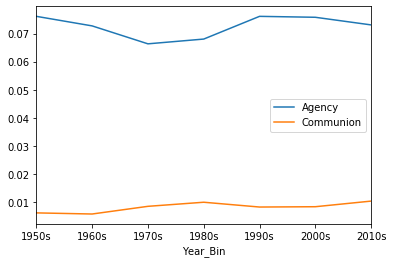

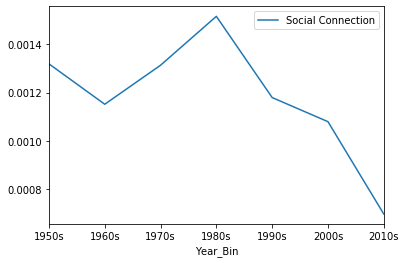

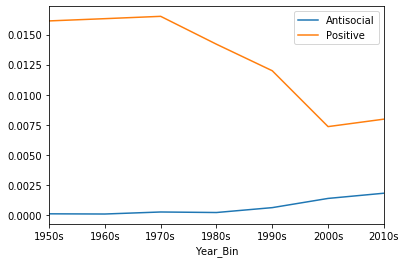

In [11]:
df = pd.DataFrame({'Agency':agency,'Communion':communion, 'Social Connection':social_connection, 'Antisocial':antisocial, 'Positive':positive, 'Year':music_df['year'],
                   'Year_Bin':music_df['year_bin']})
df['Difference'] = df['Agency']-df['Communion']
df[['Agency','Communion','Year_Bin']].groupby('Year_Bin').mean().plot();
df[['Social Connection', 'Year_Bin']].groupby('Year_Bin').mean().plot();
df[['Antisocial', 'Positive', 'Year_Bin']].groupby('Year_Bin').mean().plot();

In the original paper, they say they controlled for genre. Here we don't have that data easily accessible (we would need to collect this separately and validate it), so we're going to look for overall effects.

In [12]:
import statsmodels.formula.api as smf

mod = smf.ols(formula='Agency ~ Year', data=df)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula='Agency ~ Year_Bin', data=df)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula='Communion ~ Year', data=df)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula='Communion ~ Year_Bin', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Agency   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.536
Date:                Tue, 05 Nov 2019   Prob (F-statistic):             0.0332
Time:                        10:57:54   Log-Likelihood:                 6911.1
No. Observations:                4028   AIC:                        -1.382e+04
Df Residuals:                    4026   BIC:                        -1.381e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0982      0.080     -1.227      0.2

In [13]:
mod = smf.ols(formula='Antisocial ~ Year', data=df)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula='Antisocial ~ Year_Bin', data=df)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula='Positive ~ Year', data=df)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula='Positive ~ Year_Bin', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             Antisocial   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     179.0
Date:                Tue, 05 Nov 2019   Prob (F-statistic):           5.68e-40
Time:                        10:57:59   Log-Likelihood:                 18131.
No. Observations:                4028   AIC:                        -3.626e+04
Df Residuals:                    4026   BIC:                        -3.625e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0654      0.005    -13.246      0.0

Now that we've tested DeWall et al.'s hypothesized legisign relationships, let's expand their study to assess whether the topics of music lyrics have also changed. There may, for instance, be systematic shifts in the themes and types of acceptable language use in the songs that are not being taken into account by our regression models above and might also explain the observed shifts in language use over time. To do this, we'll first need to get the lemmas for all of the lyrics.

In [20]:
# Takes a couple minutes to run:
#lemmas = music_df['lyrics'].apply(get_lemmas)

# Save lemmas series to file so that we can access it without running the above function
#lemmas.to_pickle('lyric_lemmas.pkl')
lemmas = pd.read_pickle('lyric_lemmas.pkl')

In [22]:
# Take a look at the first couple of words in the song:
lemmas[0][:10]

['mona',
 'lisa',
 'mona',
 'lisa',
 'men',
 'name',
 "'re",
 'like',
 'lady',
 'mystic']

Notice that if we take a look at the lyrics for the first song, this isn't quite an accurate depiction of the song. The singer repeats the lyrics "Mona Lisa" over and over again, but our model separates Mona and Lisa as two separate words. We want to be able to identify words that co-occur together as phrases. To do this, we can use [colocation detection algorithms](https://radimrehurek.com/gensim/models/phrases.html) in Gensim to identify what are called "bigrams"--2 words that co-occur with one another.

In [26]:
# Build bigram and trigram models after get_lemmas to see if there's anything relevant
bigram = models.Phrases(lemmas, min_count=5)

# export trained model to use less memory:
bigram_mod = models.phrases.Phraser(bigram)

# See bigram example where Mona Lisa is now a single entity, along with "broken_heart," etc.
print(bigram_mod[lemmas[0]])

['mona_lisa', 'mona_lisa', 'men', 'name', "'re", 'like', 'lady', 'mystic', 'smile', "'cause", "'re", 'lonely', 'blame', 'mona_lisa', 'strangeness', 'smile_smile', 'tempt', 'lover', 'mona_lisa', 'way', 'hide', 'broken_heart', 'many', 'dream', 'brought', 'doorstep', 'lie', 'die', 'warm', 'real', 'mona_lisa', 'cold', 'lonely', 'lovely', 'work_art', 'smile', 'tempt', 'lover', 'mona_lisa', 'way', 'hide', 'broken_heart', 'many', 'dream', 'brought', 'doorstep', 'lie', 'die', 'warm', 'real', 'mona_lisa', 'cold', 'lonely', 'lovely', 'work_art', 'mona_lisa', 'mona_lisa']


Let's revise our lemmas to include bigrams as single phrases:

In [27]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# make bigrams
lemmas = make_bigrams(lemmas)

Now we're ready to identify topics! We are going to use an approach called LDA (Latent Dirichlet Allocation), a way of probabilistically modeling each document (song) as a mixture of a set of underlying topics. In the same way that empirical observations in an experiment are conceived to come from an underlying population distribution, documents composed of words can be said to be drawn from distributions of words ("topics"). You can read more about the theoretical background of the approach from the [original paper](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf). Greater detail on the implementation of the LDA approach in Gensim can be found in Gensim's [documentation](https://radimrehurek.com/gensim/models/ldamodel.html).

Note: One tricky thing about LDA is that you need to specify the number of topics *a priori*. There are a number of ways in which you can do this, but the way I did it was via a measure of ["topic coherence,"](https://radimrehurek.com/gensim/models/coherencemodel.html) a measurement of how coherent words in a topic are with one another (i.e. how interpretable the topics are to humans). You can see my model fitting procedure below. There are also a number of other available parameters that you may want to tune (see the gensim documentation) if you are working with topic models in the wild.

In [28]:
# Initialize Series of lemmas as Gensim Dictionary for further processing
dictionary = corpora.Dictionary([i for i in lemmas])

# Convert dictionary into bag of words format: list of (token_id, token_count) tuples
bow_corpus = [dictionary.doc2bow(text) for text in lemmas]

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.ldamulticore.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, workers=8)
        model_list.append(model)
        coherence_model = models.coherencemodel.CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

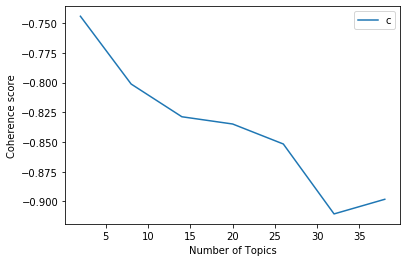

In [30]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=lemmas, start=2, limit=40, step=6)
plt.plot(range(2, 40, 6), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best');

In [65]:
# Fit optimal LDA Model based on bag of words counts for each token and return weights:
#ldamodel = models.ldamulticore.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, workers=8, passes=20, iterations=400)
# For single-core processing:
#ldamodel = models.ldamodel.LdaModel(bow_corpus, num_topics = 5, id2word=dictionary, passes=20, iterations=400)

#ldamodel.save('lda5p20_i400.model')
ldamodel = models.ldamodel.LdaModel.load('lda5p20_i400.model')
topics = ldamodel.print_topics(num_words=20)

for topic in topics:
    print(topic)

(0, '0.027*"\'m" + 0.025*"na" + 0.022*"get" + 0.021*"\'s" + 0.019*"n\'t" + 0.014*"yeah" + 0.013*"oh" + 0.011*"come" + 0.010*"want" + 0.009*"like" + 0.009*"know" + 0.009*"ca_n\'t" + 0.008*"go" + 0.008*"say" + 0.008*"good" + 0.007*"well" + 0.007*"one" + 0.007*"\'re" + 0.007*"\'ve" + 0.006*"man"')
(1, '0.035*"\'s" + 0.032*"get" + 0.019*"like" + 0.018*"\'m" + 0.011*"n\'t" + 0.011*"let" + 0.010*"yeah" + 0.009*"know" + 0.009*"go" + 0.008*"come" + 0.007*"make" + 0.007*"see" + 0.007*"wan_na" + 0.007*"back" + 0.006*"ai_n\'t" + 0.006*"girl" + 0.006*"right" + 0.006*"\'re" + 0.006*"night" + 0.006*"say"')
(2, '0.023*"yeah" + 0.021*"get" + 0.019*"\'s" + 0.019*"go" + 0.017*"oh" + 0.017*"baby" + 0.014*"know" + 0.011*"say" + 0.010*"girl" + 0.009*"\'ll" + 0.009*"\'m" + 0.009*"like" + 0.009*"come" + 0.008*"n\'t" + 0.008*"’" + 0.007*"well" + 0.007*"take" + 0.006*"tell" + 0.006*"one" + 0.006*"let"')
(3, '0.040*"love" + 0.029*"\'s" + 0.023*"n\'t" + 0.019*"know" + 0.018*"baby" + 0.017*"\'m" + 0.015*"\'re" + 

This is still a bit abstract, though. To better interpret these topics, let's identify the most representative song for each topic, so we can see what types of songs each topic refers to. It appears that topic 0 is related to empowerment (mostly women; interestingly, using the words "na-na-na-na" a lot) and topic 1 to rap/hip hop language. Topics 2 (non-english, mostly yeah yeah, starting something) and 4 (uplifting? potential?) are unclear to me. Topic 3 seems to involve a lot of songs about pleading or begging partner to take you back, forgive you, etc.

In [63]:
top_songs_by_topic = top_songs_by_topic(ldamodel, bow_corpus, ntop=10)

Topic 0
                          title  year           artist
3203                  Rich Girl  2005     Gwen Stefani
1540                 Centerfold  1982    J. Geils Band
2895                   Survivor  2001  Destiny's Child
3652                        S&M  2011          Rihanna
2087                 On Our Own  1989      Bobby Brown
2487  Here Comes The Hotstepper  1994       Ini Kamoze
2513  Here Comes The Hotstepper  1995       Ini Kamoze
3589                Ridin' Solo  2010     Jason Derulo
3137                 Sorry 2004  2004   Ruben Studdard
2399                   Bad Boys  1993     Inner Circle
*******************************
Topic 1
                    title  year                artist
2553     1st Of Tha Month  1995  Bone Thugs-N-Harmony
2847  The Real Slim Shady  2000                Eminem
2806        Ghetto Cowboy  1999       Mo Thugs Family
2726              Victory  1998            Puff Daddy
3260               Ridin'  2006        Chamillionaire
3991                 On

In [54]:
# apply to each row: axis=1, args=[bow_corpus] (see function above)
music_df = music_df.apply(fill_topic_weights, axis=1, args=[bow_corpus]).fillna(0)

In [57]:
music_df.tail()

,0,1,2,3,4,Gender,acousticness,analysis_url,artist,artist_with_features,...,num_words,pos,speechiness,tempo,time_signature,title,uri,valence,year,year_bin
4023,0.541122,0.000000,0.000000,0.197820,0.259344,female,0.08440,https://api.spotify.com/v1/audio-analysis/664g...,Alessia Cara,0,...,469,0.120,0.1660,123.909,4,Here,spotify:track:664gdARxaClFsoF5SXKOws,0.340,2015,2010s
4024,0.198195,0.497016,0.000000,0.298642,0.000000,male,0.00821,https://api.spotify.com/v1/audio-analysis/5Sf3...,Mr. Probz,Robin Schulz,...,126,0.184,0.0369,119.993,4,Waves,spotify:track:5Sf3GyLEAzJXxZ5mbCPXTu,0.450,2015,2010s
4025,0.000000,0.180031,0.537798,0.277554,0.000000,male,0.02510,https://api.spotify.com/v1/audio-analysis/0XET...,Ne-Yo,Juicy J,...,193,0.067,0.0322,139.988,4,She Knows,spotify:track:0XETcdHr7EkjfoZFSj6Asv,0.533,2015,2010s
4026,0.000000,0.000000,0.000000,0.994676,0.000000,Group,0.85900,https://api.spotify.com/v1/audio-analysis/5O2P...,One Direction,0,...,296,0.026,0.0353,120.001,4,Night Changes,spotify:track:5O2P9iiztwhomNh8xkR9lJ,0.370,2015,2010s
4027,0.000000,0.077785,0.000000,0.918267,0.000000,male,0.03890,https://api.spotify.com/v1/audio-analysis/22me...,Calvin Harris,Disciples,...,340,0.189,0.0731,122.003,4,How Deep Is Your Love,spotify:track:22mek4IiqubGD9ctzxc69s,0.336,2015,2010s


(0, '0.027*"\'m" + 0.025*"na" + 0.022*"get" + 0.021*"\'s" + 0.019*"n\'t" + 0.014*"yeah" + 0.013*"oh" + 0.011*"come" + 0.010*"want" + 0.009*"like" + 0.009*"know" + 0.009*"ca_n\'t" + 0.008*"go" + 0.008*"say" + 0.008*"good" + 0.007*"well" + 0.007*"one" + 0.007*"\'re" + 0.007*"\'ve" + 0.006*"man"')
(1, '0.035*"\'s" + 0.032*"get" + 0.019*"like" + 0.018*"\'m" + 0.011*"n\'t" + 0.011*"let" + 0.010*"yeah" + 0.009*"know" + 0.009*"go" + 0.008*"come" + 0.007*"make" + 0.007*"see" + 0.007*"wan_na" + 0.007*"back" + 0.006*"ai_n\'t" + 0.006*"girl" + 0.006*"right" + 0.006*"\'re" + 0.006*"night" + 0.006*"say"')
(2, '0.023*"yeah" + 0.021*"get" + 0.019*"\'s" + 0.019*"go" + 0.017*"oh" + 0.017*"baby" + 0.014*"know" + 0.011*"say" + 0.010*"girl" + 0.009*"\'ll" + 0.009*"\'m" + 0.009*"like" + 0.009*"come" + 0.008*"n\'t" + 0.008*"’" + 0.007*"well" + 0.007*"take" + 0.006*"tell" + 0.006*"one" + 0.006*"let"')
(3, '0.040*"love" + 0.029*"\'s" + 0.023*"n\'t" + 0.019*"know" + 0.018*"baby" + 0.017*"\'m" + 0.015*"\'re" + 

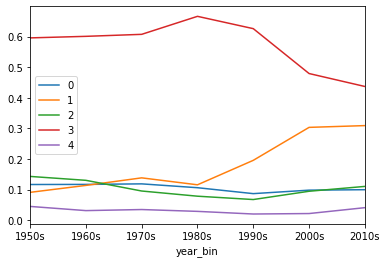

In [59]:
music_df[['0','1','2','3','4','year_bin']].groupby('year_bin').mean().plot();
for topic in topics:
    print(topic)

From the chart, we can see that Topics 0,2,4 stay pretty constant through time. Topic 1 (Rap/Hip Hop) language increases throughout the Billboard Hot 100 songs from the 80s through the 2000s -- probably a confounding factor in the DeWall et al. study (i.e. song writers are drawing from a fundamentally different language pool than was common in music prior to the 80s and 90s). If you take a look through the more recent songs, even songs from other "genres" are participating in this topic to greater extent than before. We see as well that Topic 3 (Pleading/Begging partner to take you back) decreases dramatically after the boy bands of the 90s.